# 0.0 IMPORTS

In [118]:
import pandas as pd
import numpy as np
import inflection
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import xgboost as xgb

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from boruta import BorutaPy
from datetime import datetime, timedelta
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn import ensemble as en
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import svm

warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [119]:
path = 'C:/Users/edils/repos/leilao_fechamento/data/test_petr/PETR4_B_0_5min.csv'

In [120]:
df_raw = pd.read_csv(path, encoding='iso-8859-1', sep=';')

In [121]:
df_raw

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,PETR4,26/05/2023,17:30:00,"26,79","26,80","26,76","26,79","1.518.499,00",56.700
1,PETR4,26/05/2023,16:50:00,"26,76","26,80","26,74","26,80","86.912.867,00",3.244.400
2,PETR4,26/05/2023,16:45:00,"26,77","26,80","26,74","26,77","18.082.061,00",675.700
3,PETR4,26/05/2023,16:40:00,"26,80","26,82","26,75","26,77","18.316.014,00",683.700
4,PETR4,26/05/2023,16:35:00,"26,81","26,83","26,78","26,81","23.448.773,00",874.900
...,...,...,...,...,...,...,...,...,...
14332,PETR4,30/09/2022,15:30:00,"23,39","23,46","23,39","23,46","62.166.319,00",2.077.100
14333,PETR4,30/09/2022,15:25:00,"23,45","23,49","23,38","23,39","28.148.235,00",940.600
14334,PETR4,30/09/2022,15:20:00,"23,56","23,58","23,41","23,45","47.382.040,00",1.579.800
14335,PETR4,30/09/2022,15:15:00,"23,50","23,61","23,50","23,56","25.101.653,00",833.800


## 0.2 Helper Function

In [122]:
def data_types(df1):
    #abertura
    df1['abertura'] = df1['abertura'].apply(lambda x: x.replace(',','.'))
    df1['abertura'] = df1['abertura'].astype(float)

    #maximo
    df1['maximo'] = df1['maximo'].apply(lambda x: x.replace(',','.'))
    df1['maximo'] = df1['maximo'].astype(float)

    #minimo
    df1['minimo'] = df1['minimo'].apply(lambda x: x.replace(',','.'))
    df1['minimo'] = df1['minimo'].astype(float)

    #fechamento
    df1['fechamento'] = df1['fechamento'].apply(lambda x: x.replace(',','.'))
    df1['fechamento'] = df1['fechamento'].astype(float)

    #volume
    df1['volume'] = df1['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df1['volume'] = df1['volume'].astype(float)

    #quantidade
    df1['quantidade'] = df1['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df1['quantidade'] = df1['quantidade'].apply(lambda x: float(x))

    #data
    df1['data'] = df1['data'].apply(lambda x: x.replace('/','-'))
    df1['data'] = df1['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df1['data'] = pd.to_datetime(df1['data'], format='%d-%m-%Y')
    df1['hora'] = df1['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    
    return df1

def rename_columns(df1):
    cols_old = df1.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    df1 = df1.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})
    
    return df1

def changing_time(df1):
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df1.loc[df1['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    hora_leilao = (df1['hora'].dt.hour >= 16) & (df1['hora'].dt.hour < 18) 
    df1 = df1.loc[hora_leilao,:]
    return df1

def clean_futuros(df_win):
    cols_old = df_win.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df_win.columns = cols_new
    df_win = df_win.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})

    df_win['abertura'] = df_win['abertura'].astype(float)

    #maximo

    df_win['maximo'] = df_win['maximo'].astype(float)

    #minimo

    df_win['minimo'] = df_win['minimo'].astype(float)

    #fechamento

    df_win['fechamento'] = df_win['fechamento'].astype(float)

    #volume
    df_win['volume'] = df_win['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df_win['volume'] = df_win['volume'].astype(float)

    #quantidade
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: float(x))

    #data
    df_win['data'] = df_win['data'].apply(lambda x: x.replace('/','-'))
    df_win['data'] = df_win['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df_win['data'] = pd.to_datetime(df_win['data'], format='%d-%m-%Y')
    df_win['hora'] = df_win['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df_win.loc[df_win['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    
    hora_leilao = (df_win['hora'].dt.hour >= 16) & (df_win['hora'].dt.hour < 18) 
    df_win = df_win.loc[hora_leilao,:]
    
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    return df_win

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))
   
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])
    

# 1.0 DATA DESCRIPTION 

In [275]:
df1 = df_raw.copy()

In [276]:
df1.head()

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,PETR4,26/05/2023,17:30:00,"26,79","26,80","26,76","26,79","1.518.499,00",56.700
1,PETR4,26/05/2023,16:50:00,"26,76","26,80","26,74","26,80","86.912.867,00",3.244.400
2,PETR4,26/05/2023,16:45:00,"26,77","26,80","26,74","26,77","18.082.061,00",675.700
3,PETR4,26/05/2023,16:40:00,"26,80","26,82","26,75","26,77","18.316.014,00",683.700
4,PETR4,26/05/2023,16:35:00,"26,81","26,83","26,78","26,81","23.448.773,00",874.900


In [277]:
df1 = rename_columns(df1)

In [278]:
df1 = data_types(df1)

In [279]:
df1 = changing_time(df1)

In [280]:
df1 = df1.sort_values(by='data').reset_index(drop=True)

In [281]:
df1

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade
0,PETR4,2022-09-30,1900-01-01 16:00:00,23.22,23.41,23.21,23.38,31861347.0,1068900.0
1,PETR4,2022-09-30,1900-01-01 17:30:00,23.38,23.46,23.32,23.35,16077741.0,538800.0
2,PETR4,2022-09-30,1900-01-01 16:50:00,23.46,23.48,23.33,23.33,350662189.0,11760900.0
3,PETR4,2022-09-30,1900-01-01 16:45:00,23.46,23.48,23.40,23.45,26630327.0,889200.0
4,PETR4,2022-09-30,1900-01-01 16:40:00,23.42,23.46,23.41,23.44,26118333.0,872500.0
...,...,...,...,...,...,...,...,...,...
3435,PETR4,2023-05-26,1900-01-01 16:10:00,26.82,26.82,26.78,26.79,19614855.0,731700.0
3436,PETR4,2023-05-26,1900-01-01 16:05:00,26.83,26.83,26.80,26.81,3368292.0,125600.0
3437,PETR4,2023-05-26,1900-01-01 16:00:00,26.85,26.86,26.81,26.83,4983569.0,185700.0
3438,PETR4,2023-05-26,1900-01-01 16:55:00,26.80,26.83,26.80,26.81,5929336.0,221200.0


## Splitting Test Train

In [282]:
data_test = pd.to_datetime('2023-05-19')

In [283]:
X_test = df1.loc[df1['data'] > data_test,:]

In [284]:
X_train = df1.loc[df1['data'] <= data_test,:]

In [287]:
X_test.to_csv('X_test_arima.csv', index=False)
X_train.to_csv('X_train_arima.csv', index=False)

In [194]:
X_train = X_train.drop(['ativo','data','hora','abertura','maximo','minimo','volume','quantidade'], axis=1)


In [195]:
X_test = X_test.drop(['ativo','data','hora','abertura','maximo','minimo','volume','quantidade'], axis=1)

In [196]:
training_set = X_train.values

In [197]:
print(training_set)
training_set.shape

[[23.38]
 [23.35]
 [23.33]
 ...
 [25.95]
 [25.93]
 [25.85]]


(3325, 1)

## 2.0 Scalling

In [200]:
mms = MinMaxScaler()
scaled_training_set = mms.fit_transform(training_set)

In [201]:
scaled_training_set

array([[0.40747331],
       [0.40480427],
       [0.40302491],
       ...,
       [0.636121  ],
       [0.63434164],
       [0.6272242 ]])

# 3.0 Preparing Data

In [202]:
n_steps = 60

In [240]:
X_train_lstm = []
y_train_lstm = []

for i in range(n_steps, len(training_set)):
    X_train_lstm.append(scaled_training_set[i-n_steps:i,0])
    y_train_lstm.append(scaled_training_set[i, 0])
    
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

In [241]:
print(X_train_lstm.shape)
print(y_train_lstm.shape)

(3265, 60)
(3265,)


# 4.0 Reshape for LSTM

In [242]:
X_train_lstm = np.reshape(X_train_lstm,(X_train_lstm.shape[0], X_train_lstm.shape[1],1))

In [243]:
X_train_lstm.shape

(3265, 60, 1)

In [245]:
X_train_lstm

array([[[0.40747331],
        [0.40480427],
        [0.40302491],
        ...,
        [0.64857651],
        [0.65302491],
        [0.65836299]],

       [[0.40480427],
        [0.40302491],
        [0.41370107],
        ...,
        [0.65302491],
        [0.65836299],
        [0.65391459]],

       [[0.40302491],
        [0.41370107],
        [0.41281139],
        ...,
        [0.65836299],
        [0.65391459],
        [0.68149466]],

       ...,

       [[0.61565836],
        [0.61565836],
        [0.6183274 ],
        ...,
        [0.6316726 ],
        [0.63256228],
        [0.63345196]],

       [[0.61565836],
        [0.6183274 ],
        [0.6183274 ],
        ...,
        [0.63256228],
        [0.63345196],
        [0.636121  ]],

       [[0.6183274 ],
        [0.6183274 ],
        [0.62099644],
        ...,
        [0.63345196],
        [0.636121  ],
        [0.63434164]]])

# 5.0 Training LSTM

In [246]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train_lstm.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [247]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32)

Epoch 1/20
103/103 [==============================] - 10s 46ms/step - loss: 0.0084
Epoch 2/20
103/103 [==============================] - 5s 48ms/step - loss: 0.0030
Epoch 3/20
103/103 [==============================] - 5s 46ms/step - loss: 0.0028
Epoch 4/20
103/103 [==============================] - 5s 46ms/step - loss: 0.0025
Epoch 5/20
103/103 [==============================] - 5s 48ms/step - loss: 0.0021
Epoch 6/20
103/103 [==============================] - 5s 46ms/step - loss: 0.0021
Epoch 7/20
103/103 [==============================] - 5s 46ms/step - loss: 0.0019
Epoch 8/20
103/103 [==============================] - 5s 47ms/step - loss: 0.0019
Epoch 9/20
103/103 [==============================] - 5s 46ms/step - loss: 0.0018
Epoch 10/20
103/103 [==============================] - 5s 46ms/step - loss: 0.0016
Epoch 11/20
103/103 [==============================] - 5s 45ms/step - loss: 0.0016
Epoch 12/20
103/103 [==============================] - 5s 48ms/step - loss: 0.0013
Epoch 13/20


## Testing model

In [248]:
dataset_test = X_test
dataset_train = X_train

In [249]:
actual_stock_price = dataset_test.values

In [250]:
dataset_total = pd.concat((dataset_train['fechamento'], dataset_test['fechamento']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test)-60:].values

In [251]:
inputs = inputs.reshape(-1,1)

In [252]:
inputs = mms.transform(inputs)

In [270]:
X_test_lstm = []
for i in range(60,175):#dados do test+60
    X_test_lstm.append(inputs[i-60:i, 0])
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1],1))


In [271]:
X_test_lstm.shape

(115, 60, 1)

In [272]:
predicted_stock_price = regressor.predict(X_test_lstm)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)

4/4 [==============================] - 0s 16ms/step


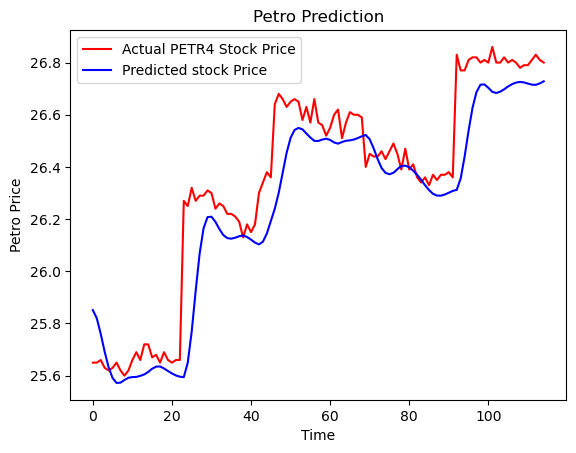

In [273]:
plt.plot(actual_stock_price, color='red', label = 'Actual PETR4 Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted stock Price')
plt.title('Petro Prediction')
plt.xlabel('Time')
plt.ylabel('Petro Price')
plt.legend()

In [274]:
X_test_lstm

array([[[0.6183274 ],
        [0.62099644],
        [0.63790036],
        ...,
        [0.636121  ],
        [0.63434164],
        [0.6272242 ]],

       [[0.62099644],
        [0.63790036],
        [0.62366548],
        ...,
        [0.63434164],
        [0.6272242 ],
        [0.6094306 ]],

       [[0.63790036],
        [0.62366548],
        [0.62099644],
        ...,
        [0.6272242 ],
        [0.6094306 ],
        [0.6094306 ]],

       ...,

       [[0.69839858],
        [0.69217082],
        [0.69661922],
        ...,
        [0.71085409],
        [0.71085409],
        [0.71263345]],

       [[0.69217082],
        [0.69661922],
        [0.69128114],
        ...,
        [0.71085409],
        [0.71263345],
        [0.71441281]],

       [[0.69661922],
        [0.69128114],
        [0.69928826],
        ...,
        [0.71263345],
        [0.71441281],
        [0.71263345]]])